In [1]:
!pip install wfdb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
from scipy.signal import butter, filtfilt
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
path_A = "/kaggle/input/minor-project-dataset/set-a/set-a"
path_B = "/kaggle/input/minor-project-dataset/set-b/set-b"
output_train = "/kaggle/working/final_train.csv"
output_test = "/kaggle/working/final_test.csv"
train=[]
test=[]

In [4]:
def plot_signal_stages(df, channel='AECG1', record_id=None, num_samples=2000):
    idx = (df['record_id'] == record_id) if record_id else slice(None)
    plt.figure(figsize=(14,4))
    plt.plot(df.loc[idx, channel].values[:num_samples])
    plt.title(f"{channel} for record {record_id if record_id else ''} (First {num_samples} samples)")
    plt.xlabel('Sample Index'); plt.ylabel('Amplitude')
    plt.show()

def plot_qrs_peaks(df, channel='AECG1', record_id=None, num_samples=2000):
    df_plot = df[df['record_id'] == record_id] if record_id else df
    plt.figure(figsize=(18,4))
    plt.plot(df_plot[channel][:num_samples], label='ECG Signal')
    qrs_idxs = df_plot[df_plot['qrs_peak'] == 1].index.values
    qrs_idxs = qrs_idxs[qrs_idxs < df_plot.index[0] + num_samples]
    plt.scatter(qrs_idxs - df_plot.index[0], df_plot[channel].loc[qrs_idxs], c='red', label="QRS Peaks")
    plt.xlabel('Sample Index'); plt.ylabel('Amplitude')
    plt.title(f"QRS Peaks on {channel} ({record_id})")
    plt.legend()
    plt.show()

def plot_channel_distribution(df, channels=['AECG1','AECG2','AECG3','AECG4']):
    plt.figure(figsize=(12, 6))
    for ch in channels:
        sns.histplot(df[ch], kde=True, label=ch, bins=100, element='step')
    plt.title("Distribution of Signal Values (All Channels)")
    plt.legend()
    plt.show()

def plot_label_imbalance(df, label_col='qrs_peak'):
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[label_col].fillna('NaN'))
    plt.title(f'Label Distribution: {label_col}')
    plt.show()

def plot_window(window, label=None, channels=['AECG1','AECG2','AECG3','AECG4']):
    plt.figure(figsize=(14,4))
    for i, ch in enumerate(channels):
        plt.plot(window[:, i], label=ch)
    if label is not None:
        peaks = np.where(label == 1)[0]
        for i in peaks:
            plt.axvline(i, color='r', alpha=0.3)
    plt.legend()
    plt.title("Sample window (vertical lines = QRS)")
    plt.show()

def plot_rr_intervals(df, record_id=None):
    df_plot = df[df['record_id'] == record_id] if record_id else df
    qrs_peaks = df_plot[df_plot['qrs_peak']==1].index.values
    rr_int = np.diff(qrs_peaks)
    plt.figure(figsize=(8,4))
    plt.hist(rr_int, bins=50)
    plt.title(f"RR Interval Histogram ({record_id})")
    plt.xlabel("Samples between peaks"); plt.ylabel("Count")
    plt.show()


In [5]:
def bandPass (signal, low, high, fs, order=4):
    ny= 0.5*fs
    l,h = low/ny, high/ny
    b,a = butter(order, [l,h], btype="band")
    signal = np.nan_to_num(signal, nan=0.0, posinf=0.0, neginf=0.0)
    return filtfilt(b,a,signal,padlen=3*(max(len(b), len(a))-1))


In [6]:
records_A = sorted(set(os.path.splitext(f)[0] for f in os.listdir(path_A) if f.endswith('.hea')))
records_B = sorted(set(os.path.splitext(f)[0] for f in os.listdir(path_B) if f.endswith('.hea')))

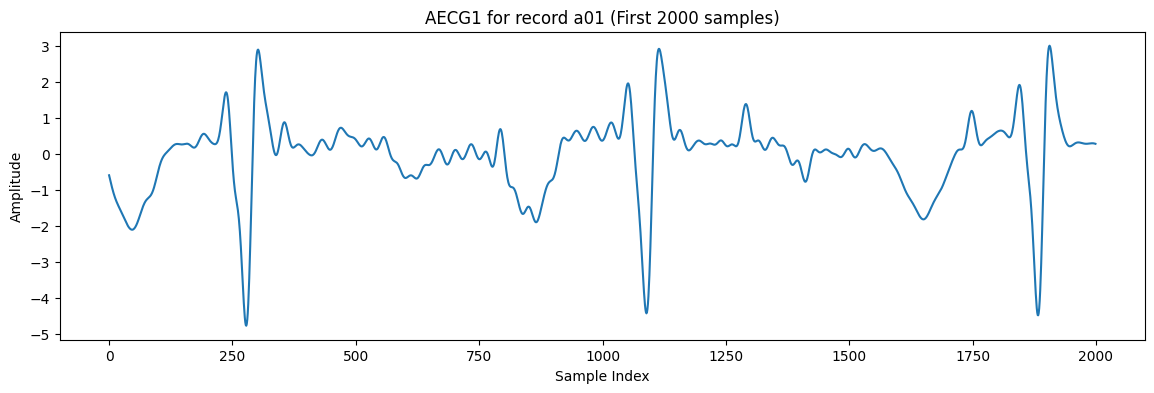

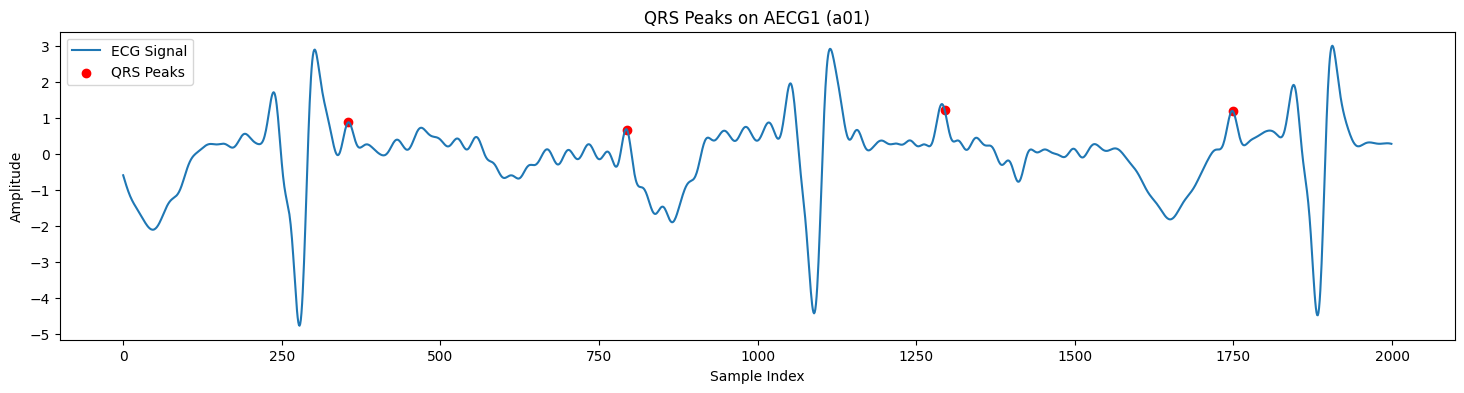

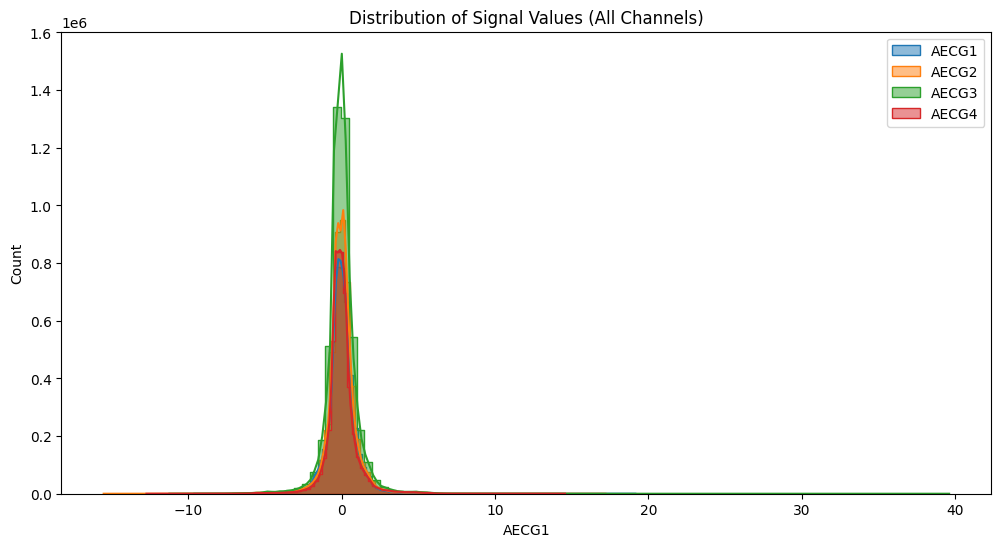

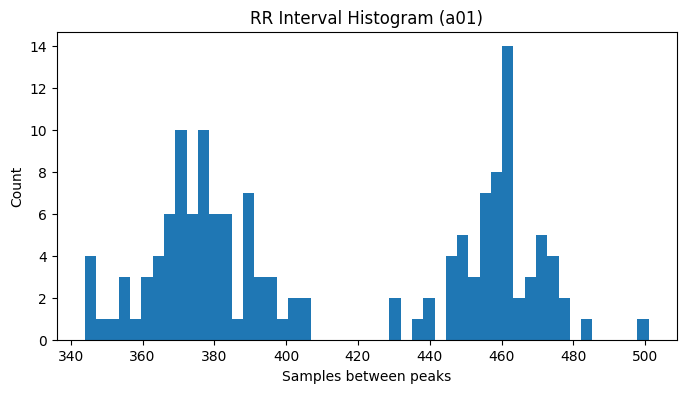

In [7]:
for rec1 in records_A:
    recordA = wfdb.rdrecord(os.path.join(path_A, rec1))
    fs1=recordA.fs
    signalA_df = pd.DataFrame(recordA.p_signal, columns=recordA.sig_name)
    signalA_df.insert(0, "sample_index", np.arange(len(signalA_df)))
    signalA_df.insert(1, "record_id", rec1)
    for col1 in recordA.sig_name:
        signalA_df[col1] = bandPass(signalA_df[col1], 0.5, 40, fs1)
    for col1 in recordA.sig_name:
        signalA_df[col1] = (signalA_df[col1] - signalA_df[col1].mean()) / signalA_df[col1].std()
    try:
        annA=wfdb.rdann(os.path.join(path_A, rec1),'fqrs')
        signalA_df["qrs_peak"]=0
        signalA_df.loc[annA.sample, "qrs_peak"] =1
    except:
        signalA_df["qrs_peak"] = np.nan
    if rec1 == records_A[0]:
        plot_signal_stages(signalA_df, channel='AECG1', record_id=rec1)
        plot_qrs_peaks(signalA_df, channel='AECG1', record_id=rec1)
    
    train.append(signalA_df)
final_train = pd.concat(train, ignore_index=True)
plot_channel_distribution(final_train)
plot_rr_intervals(final_train, record_id=records_A[0])

In [8]:
final_train

,sample_index,record_id,AECG1,AECG2,AECG3,AECG4,qrs_peak
0,0,a01,-0.588556,-0.035593,0.371286,-0.087699,0
1,1,a01,-0.648035,-0.037746,0.378270,-0.095798,0
2,2,a01,-0.707089,-0.040325,0.385291,-0.104620,0
3,3,a01,-0.765372,-0.043566,0.392391,-0.114559,0
4,4,a01,-0.822549,-0.047677,0.399613,-0.125946,0
...,...,...,...,...,...,...,...
4499995,59995,a75,0.259959,0.278041,0.299607,0.318991,0
4499996,59996,a75,0.247271,0.263906,0.284012,0.302276,0
4499997,59997,a75,0.235059,0.250115,0.268686,0.285900,0
4499998,59998,a75,0.223078,0.236477,0.253465,0.269702,0


In [9]:
for rec2 in records_B:
    recordB = wfdb.rdrecord(os.path.join(path_B, rec2))
    signalB_df = pd.DataFrame(recordB.p_signal, columns=recordB.sig_name)
    fs2=recordB.fs
    signalB_df.insert(0, "sample_index", np.arange(len(signalB_df)))
    signalB_df.insert(1, "record_id", rec2)
    for col2 in recordB.sig_name:
        signalB_df[col2] = bandPass(signalB_df[col2], 0.5, 40, fs2)
    for col2 in recordB.sig_name:
        signalB_df[col2] = (signalB_df[col2]-signalB_df[col2].mean()) / signalB_df[col2].std()
    
    test.append(signalB_df)
temp = pd.concat(test, ignore_index=True)

In [10]:
temp

,sample_index,record_id,AECG1,AECG2,AECG3,AECG4
0,0,b00,1.283807,1.086350,1.256669,1.272392
1,1,b00,1.456924,1.290164,1.489111,1.508165
2,2,b00,1.627309,1.489855,1.715983,1.737519
3,3,b00,1.792249,1.681506,1.932124,1.954469
4,4,b00,1.949377,1.861691,2.133003,2.153743
...,...,...,...,...,...,...
5999995,59995,b99,0.021161,-0.111998,-0.029644,-0.137715
5999996,59996,b99,0.021396,-0.101303,-0.024441,-0.126562
5999997,59997,b99,0.022576,-0.089352,-0.018120,-0.114325
5999998,59998,b99,0.024445,-0.076578,-0.011056,-0.101327


In [11]:
final_test=temp.iloc[:3900000]
final_validation=temp.iloc[3900000:]

In [12]:
final_test

,sample_index,record_id,AECG1,AECG2,AECG3,AECG4
0,0,b00,1.283807,1.086350,1.256669,1.272392
1,1,b00,1.456924,1.290164,1.489111,1.508165
2,2,b00,1.627309,1.489855,1.715983,1.737519
3,3,b00,1.792249,1.681506,1.932124,1.954469
4,4,b00,1.949377,1.861691,2.133003,2.153743
...,...,...,...,...,...,...
3899995,59995,b64,0.578712,0.737561,0.186122,-0.032037
3899996,59996,b64,0.536256,0.682708,0.174678,-0.021527
3899997,59997,b64,0.491754,0.625012,0.164633,-0.002790
3899998,59998,b64,0.445921,0.565437,0.155732,0.022334


In [13]:
final_validation

,sample_index,record_id,AECG1,AECG2,AECG3,AECG4
3900000,0,b65,-0.083270,-0.077808,-0.016389,-0.130192
3900001,1,b65,1.733206,0.969708,1.976620,1.183539
3900002,2,b65,3.504025,1.991164,3.919532,2.464104
3900003,3,b65,5.186069,2.961973,5.765112,3.680185
3900004,4,b65,6.741200,3.860371,7.471574,4.804058
...,...,...,...,...,...,...
5999995,59995,b99,0.021161,-0.111998,-0.029644,-0.137715
5999996,59996,b99,0.021396,-0.101303,-0.024441,-0.126562
5999997,59997,b99,0.022576,-0.089352,-0.018120,-0.114325
5999998,59998,b99,0.024445,-0.076578,-0.011056,-0.101327


In [14]:
final_train.to_csv("Train", index=False)

In [15]:
final_test.to_csv("Test",index=False)

In [16]:
final_validation.to_csv("Validate", index=False)

In [17]:
fs=1000
window_size_seconds = 5
window_size_samples = window_size_seconds * fs
overlap_percentage = 0.5
step_size_samples = int(window_size_samples * (1 - overlap_percentage))
channels = ['AECG1', 'AECG2', 'AECG3', 'AECG4']

In [18]:
def creating_window(df, qrspeakcolumn="qrs_peak", channels=channels):
    signal=df[channels].values
    qrs_peaks = df.index[df[qrspeakcolumn]==1].to_numpy() if qrspeakcolumn in df.columns else None
    windows=[]
    labels=[]
    for start in range (0,len(signal) - window_size_samples, step_size_samples):
        end=start+window_size_samples
        window = signal[start:end,:]
        windows.append(window)
        if qrs_peaks is not None:
            mask=np.zeros(window.shape[0])
            peaks_in_window=qrs_peaks[(qrs_peaks>=start) & (qrs_peaks<end)] - start
            valid = (peaks_in_window >= 0) & (peaks_in_window < window.shape[0])
            peaks_in_window_valid = peaks_in_window[valid].astype(int)
            mask[peaks_in_window_valid] = 1
            labels.append(mask)
    if qrs_peaks is not None:
        return np.array(windows), np.array(labels)
    else:
        return np.array(windows)

In [19]:
train_windows, train_labels = creating_window(final_train)
test_windows = creating_window(final_test, qrspeakcolumn=None)
validation_windows = creating_window(final_validation, qrspeakcolumn=None)

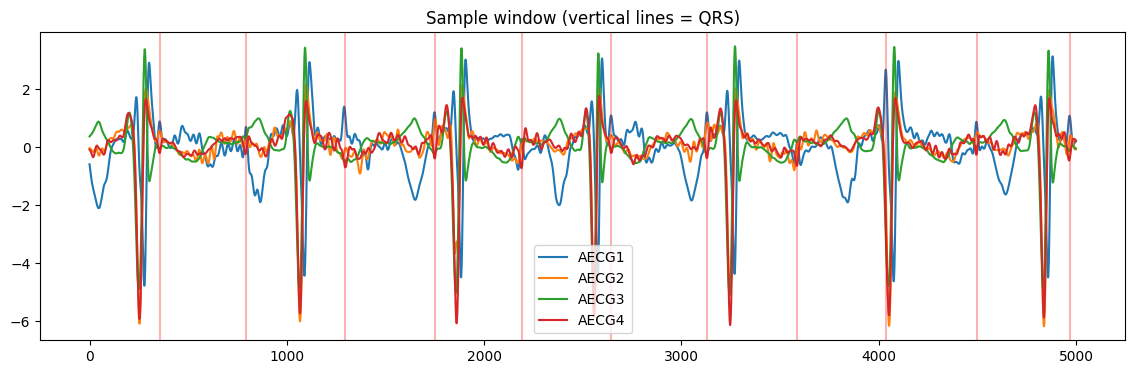

In [20]:
plot_window(train_windows[0], train_labels[0])

In [21]:
np.save("train_windows.npy",train_windows)
np.save("train_labels.npy",train_labels)
np.save("test_windows.npy",test_windows)
np.save("validation_windows.npy",validation_windows)